In [262]:
import qiskit
import time
from matplotlib import pyplot as plt

In [4]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.10.0',
 'qiskit-aer': '0.3.2',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.3.3',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.13.0'}

In [5]:
from qiskit import IBMQ
import numpy as np

In [6]:
#IBMQ.save_account('488a01d1ced1b582bb3182aa638da3e3571b07af5f757f78ad1d05a9f0dfec77bbbf44eb3563259f5238ff2b0fadd3963202ab72b45a65671caa9c47b492882f')

## Solving QAOA 1D ISING model given n, with  p = 1 

Solving for $H = \sum_{j=1}^{n} J_j \sigma_j^z \sigma_{j+1}^z +  \sum_{j=1}^{n}h_j \sigma_j^x$, note $h = 0$ for the classic Ising model which is what we're solving here, we sample the parameters $J_j$ from a normal distribution with zero mean and unit variance, and choose two arbitrary $\gamma,\beta$


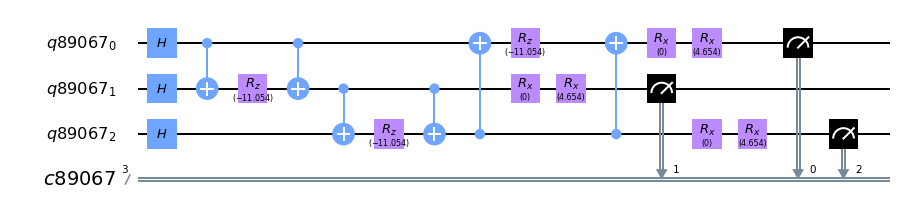

In [170]:
from qiskit import*
import numpy as np

n = 3
# normal sample for J's and h's
J = np.random.normal(0, 1, n)
hj = np.random.normal(0, 1, n)
# set J,h to1 for all

for i in range(n):
    J[i] = -1
    hj[i] = 0

J = [-1,-1,-1]

gamma = 5.527
beta = 2.327


qr = QuantumRegister(n)
cr = ClassicalRegister(n)

circuit = QuantumCircuit(qr, cr)

# Add a H gate on all qubits
for i in range(n):
    circuit.h(qr[i])
    
    
# apply U(gamma)
  
for i in range(n-1):
    circuit.cx(qr[i], qr[i+1])
    circuit.rz(2*gamma*J[i], qr[i+1])
    circuit.cx(qr[i], qr[i+1])
    
# last one n loops to n=0
circuit.cx(qr[n-1], qr[0])
circuit.rz(2*gamma*J[0], qr[0])
circuit.cx(qr[n-1], qr[0])

# apply U(beta)
for i in range(n):
    circuit.rx(2*gamma*hj[i],qr[i])
    circuit.rx(2*beta,qr[i])

circuit.measure(qr,cr)

circuit.draw(output='mpl')


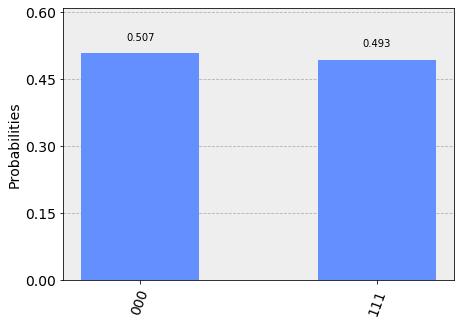

In [171]:
from qiskit.visualization import plot_histogram

# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

tot_counts = 1000

result = execute(circuit, simulator, shots=tot_counts).result()
counts = result.get_counts(circuit)
plot_histogram(counts)

In [169]:
# Function to construct basis vectors
def basisF(bKey, bDict):
    
    p1, p2, p3 = bDict[bKey]
    
    if p1 == 1:
        v1 = [1,0]
    else:
        v1 = [0,1]
        
    if p2 == 1:
        v2 = [1,0]
    else:
        v2 = [0,1]
        
    if p3 == 1:
        v3 = [1,0]
    else:
        v3 = [0,1]
    
    return np.kron(np.kron(v1, v2), v3)

Calculating expectation for $H_{cost} = \sum_{j=1}^{n} J_j \sigma_j^z \sigma_{j+1}^z$

In [83]:
def exp_n3(counts,tot_counts, J):
    # Calculate the expectations for n = 3
    I = np.identity((2))
    X = [[0,1],[1,0]]
    Z = [[1,0],[0,-1]]
    z1 = np.kron(Z,np.kron(I,I))
    z2 = np.kron(I,np.kron(Z,I))
    z3 = np.kron(I,np.kron(I,Z))

    # Hc is diagonal
    Hc = J[0]*np.dot(z1,z2)+J[1]*np.dot(z2,z3)+J[2]*np.dot(z1,z3)
#     Hc = z3
    
    # Basis dict
    basisDict = {'000': [0,0,0], '010': [0,1,0], '001': [0,0,1], '101': [1,0,1], '110': [1,1,0], '100': [1,0,0], '011': [0,1,1], '111': [1,1,1]}
    
#     state = np.empty((2**n))
    cont = 0
    exptI = 0.0
    state = np.zeros((8,))
    for i in counts.keys():
#         state[cont] = (counts[i]/tot_counts)**1
        basisVec = basisF(i, basisDict)
        thisState = np.sqrt(counts[i]/tot_counts)*basisVec
        state = state + thisState
        exptI = exptI + (counts[i]/tot_counts)*np.matmul( np.transpose(basisVec), np.matmul(Hc, basisVec))
        cont = cont+1
    
#     print(exptI)
#     basisVec = basisF('110', basisDict)
#     print( np.matmul( np.transpose(basisVec), np.matmul(Hc, basisVec)) )
        
    # Compute expectation
    expt = np.matmul( np.transpose(state), np.matmul(Hc, state))

#     return np.sum(np.dot(Hc,state))
    return expt

# print(exp_n3(counts,tot_counts,J))

QAOA function for a given number of sample angle pairs (p = 1):

In [297]:
# QAOA body 

def qaoa_counts(n, J, h, tot_counts, beta, gamma,p): 
    
    
    qr = QuantumRegister(n)
    cr = ClassicalRegister(n)

    circuit = QuantumCircuit(qr, cr)

    if (p == 1):
        
        # Add a H gate on all qubits
        for i in range(n):
            circuit.h(qr[i])

        # apply U(gamma)

        for i in range(n-1):
            circuit.cx(qr[i], qr[i+1])
            circuit.rz(2*gamma*J[i], qr[i+1])
            circuit.cx(qr[i], qr[i+1])

        # last one n loops to n=0
        circuit.cx(qr[n-1], qr[0])
        circuit.rz(2*gamma*J[0], qr[0])
        circuit.cx(qr[n-1], qr[0])

        # apply U(beta)
        for i in range(n):
#             circuit.rx(2*gamma*h[i],qr[i])
            circuit.rx(2*beta,qr[i])
    
    else: 
        
        # Add an H gate on all qubits (just once not every p)
        for i in range(n):
            circuit.h(qr[i])
        
        # apply U(gamma) and then U(beta) succesively 
        for k in range(p):

            # apply U(gamma)

            for i in range(n-1):
                circuit.cx(qr[i], qr[i+1])
                circuit.rz(2*gamma[k]*J[i], qr[i+1])
                circuit.cx(qr[i], qr[i+1])

            # last one n loops to n=0
            circuit.cx(qr[n-1], qr[0])
            circuit.rz(2*gamma[k]*J[0], qr[0])
            circuit.cx(qr[n-1], qr[0])

            
            # apply U(beta)
            for i in range(n):
#                 circuit.rx(2*gamma[k]*h[i],qr[i])
                circuit.rx(2*beta[k],qr[i])


    circuit.measure(qr,cr)

    simulator = Aer.get_backend('qasm_simulator')

    tot_counts = 1000

    result = execute(circuit, simulator, shots=tot_counts).result()
    counts = result.get_counts(circuit)


    return counts


In [210]:
# QAOA function for a given p = 2 for now

def qaoa_n3(samples,anglesRandom,p,J):
    n = 3
    res = np.empty(samples) 
    
    if (p == 1):
        beta_res = np.empty((samples))
        gamma_res = np.empty((samples))
    else:
        beta_res = np.empty((samples,p))
        gamma_res = np.empty((samples,p))

    
    # number of shots to run
    tot_counts = 1000
    
    # normal sample for J's and h's 
#     J = np.random.uniform(0, 1, n) 
    h = np.random.uniform(0, 1, n)

    for i in range(n):
#         J[i] = -1 
        h[i] = 0
#     J = [1,1/np.sqrt(2),1/np.sqrt(2)]
#     J = [1,0.9,0.9]
    
    if (anglesRandom == False and p == 1):
        # step to make exactly samples number of samples
        # input samples should be a perfect square
        size_m = np.sqrt(samples)
        beta = np.linspace(0,np.pi/2, size_m)
        gamma = np.linspace(0,np.pi*2, size_m)
        
        for i in range(beta.shape[0]):
            for j in range(gamma.shape[0]):
                k = beta.shape[0]*i+j
                counts = qaoa_counts(n,J,h,tot_counts,beta[i],gamma[j],p)
                res[k] = exp_n3(counts,tot_counts,J)
                beta_res[k] = beta[i]
                gamma_res[k] = gamma[j]
       
    else:
        
        for k in range(samples):

            # beta from 0 to pi/2 due to periodicity considerations
            beta = np.random.uniform(0, np.pi/2, p)
            gamma = np.random.uniform(0, np.pi*2, p)
            
            counts = qaoa_counts(n,J,h,tot_counts, beta, gamma,p)
            res[k] = exp_n3(counts,tot_counts,J)
            
            if (p == 1):
                beta_res[k] = beta
                gamma_res[k] = gamma
            else: 
                beta_res[k,:] = beta
                gamma_res[k,:] = gamma

    
    return res,beta_res,gamma_res

In [234]:
sT = time.time()
# for the number of samples please give a perfect square if using False
samples = 10000

res,beta_res,gamma_res = qaoa_n3(samples, True,1,[1,-0.25,0.25])


eT = time.time()
print('Elapsed time: ' + str(eT-sT))

Elapsed time: 270.75168895721436


In [251]:
imin = np.argmin(res)
print(res[imin]) 
print(beta_res[imin])
print(gamma_res[imin])

-1.0114999999999998
0.39661104925394913
3.1663509998016384


In [256]:
print(res[imin]) 

beta_first = beta_res[imin]
gamma_first = gamma_res[imin]

    
guesses = np.empty((2,p))
guesses[0,:] = beta_first
guesses[1,:] = gamma_first

mm = minimize(qaoa_expect,guesses, method='BFGS')

-1.0114999999999998


In [257]:
print(qaoa_expect(mm.x))

-1.0095


In [231]:
# make contour plot on angles vs expectation

res,beta_res,gamma_res = qaoa_n3(5000, False,1,[1,-0.25,0.25])

KeyboardInterrupt: 

In [218]:
imin = np.argmin(res)
print(res[imin]) 
print(beta_res[imin])
print(gamma_res[imin])

-1.0105
0.38468481472528077
3.2057067893773397


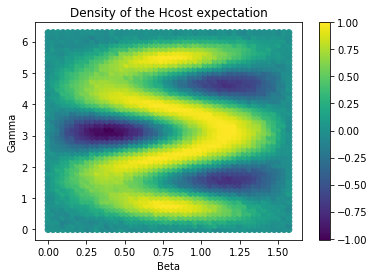

In [219]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.colorbar(ax.scatter(beta_res, gamma_res, c=res))
plt.xlabel("Beta")
plt.ylabel("Gamma")
plt.title('Density of the Hcost expectation')
plt.show()

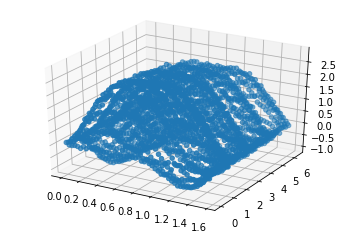

In [137]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(beta_res, gamma_res, res, cmap='hot', marker='o')
plt.show()

In [240]:
# function to minimize
# J = [1,0.9,0.9]
J = [1,-0.25,0.25]
p = 1
def qaoa_expect(angles):
    beta = angles[:p]
    gamma = angles[p:]

    n,h,tot_counts = 3,[0,0,0],1000
    counts = qaoa_counts(n,J,h,tot_counts, beta, gamma,p)
    return exp_n3(counts,tot_counts,J)


In [75]:
from scipy.optimize import minimize

# Run 1000 samples, obtain first optimal min for beta gamma, then run again to obtain a better min
p = 1
# run with random angles
res,beta_res,gamma_res = qaoa_n3(1000, True,p,J)
imin_first = np.argmin(res)

if (p == 1):
    beta_first = beta_res[imin_first]
    gamma_first = gamma_res[imin_first]
else:
    beta_first = beta_res[imin_first,:]
    gamma_first = gamma_res[imin_first,:]
guesses = np.empty((2,p))
guesses[0,:] = beta_first
guesses[1,:] = gamma_first



In [80]:
# Optimize objective funciton with the first guesses
mm = minimize(qaoa_expect,guesses, method='BFGS')

AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA
AAAAA


In [81]:
print(qaoa_expect(mm.x))

AAAAA
-0.1974000000000001


Check QAOA accuracy with respect to lowest classical eigenvalue calculation. Fix $J_{12} = 1$ and make $J_{23},J_{13} \in [-1,1]$


In [277]:
# Classical n = 3
from numpy import linalg as LA

def minEig(J):

    I = np.identity((2))
    Z = [[1,0],[0,-1]]
    z1 = np.kron(Z,np.kron(I,I))
    z2 = np.kron(I,np.kron(Z,I))
    z3 = np.kron(I,np.kron(I,Z))

    zs = J[0]*np.dot(z1,z2)+J[1]*np.dot(z2,z3)+J[2]*np.dot(z1,z3)

    H = zs 
    e_val,e_vect = LA.eig(H)
    
    return np.min(e_val)

In [347]:
def opt_QAOA(J,p,samples):
    res,beta_res,gamma_res = qaoa_n3(samples, True,p,J)
    
    if (p == 1):
        imin_first = np.argmin(res)
        beta_first = beta_res[imin_first]
        gamma_first = gamma_res[imin_first]
        guesses = np.empty((2))
        guesses[0] = beta_first
        guesses[1] = gamma_first
    else:
        imin_first = np.argmin(res)
        beta_first = beta_res[imin_first,:]
        gamma_first = gamma_res[imin_first,:]
        guesses = np.empty((2*p))
        guesses[:p] = beta_first
        guesses[p:] = gamma_first
    
    def qaoa_expct(angles):
        beta = angles[:p]
        gamma = angles[p:]

        n,h,tot_counts = 3,[0,0,0],1000
        counts = qaoa_counts(n,J,h,tot_counts, beta, gamma,p)
        return exp_n3(counts,tot_counts,J)
    # Optimize objective funciton with the first guesses
    mm = minimize(qaoa_expct,guesses, method='BFGS')
    print(guesses)
    return qaoa_expct(mm.x)


In [279]:
num_examples = 25
j23 = np.linspace(-1,1,num_examples)
j13 = np.linspace(-1,1,num_examples)
j12 = np.ones(num_examples)

J13 = np.empty((num_examples**2)) 
J23 = np.empty((num_examples**2))

 
samples = 10  

delta_expcts = np.empty((num_examples**2))

for i in range(num_examples):
    for j in range(num_examples):
        k = num_examples*i+j
        J13[k] = j13[i]
        J23[k] = j23[j]

        J = [1,j23[j],j13[i]]
        ce = minEig(J)
        qe = opt_QAOA(J,1,samples)
        delta_expcts[k] = qe-ce

/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-pack

/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-pack

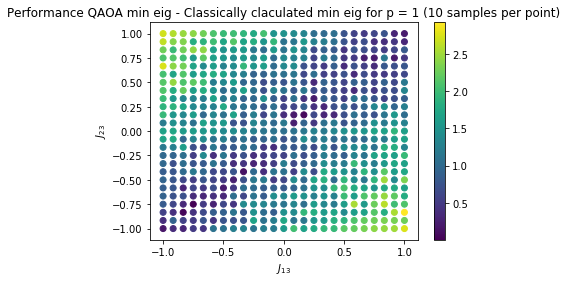

In [280]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.colorbar(ax.scatter(J13, J23, c=delta_expcts))
plt.xlabel("$J_{13}$")
plt.ylabel("$J_{23}$")
plt.title('Performance QAOA min eig - Classically claculated min eig for p = 1 (' + str(samples) + ' samples per point)')
plt.show()

12
12


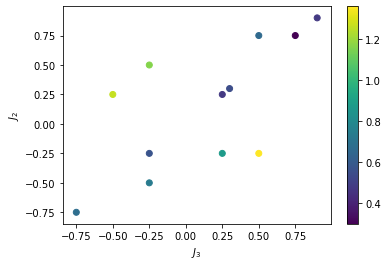

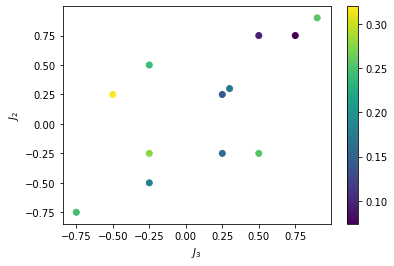

In [354]:
# for yorktown results
J3_Y = [0.9,0.25,-0.25,0.75,-0.75,0.25,0.50,-0.25,0.3,-0.25,-0.5,0.5]
J2_Y = [0.9,0.25,-0.25,0.75,-0.75,-0.25,-0.25,-0.50,0.3,0.5,0.25,0.75]

J = []

for i in range(len(J2_Y)):
    J.append("[1,"+ str(J2_Y[i])+","+str(J3_Y[i])+"]")
   

 
true = np.asarray([-1,-1,-1,-1,-1,-1.5,-1.75,-1.25,-1,-1.75,-1.75,-1.25])
qas = np.asarray([-0.775,-0.664,-0.701,-0.775,-0.569,-0.781,-0.643,-0.692,-0.623,-0.829,-0.802,-0.687])
york = np.asarray([-0.519,-0.521,-0.424,-0.701,-0.323,-0.623,-0.389,-0.512,-0.452,-0.587,-0.482,-0.590])

york_true = np.subtract(york,true)
york_qasm = np.subtract(york,qas)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.colorbar(ax.scatter(J3_Y, J2_Y, c=york_true))
plt.xlabel("$J_{3}$")
plt.ylabel("$J_{2}$")
#plt.title('Performance Yorktown QAOA - true value for p = 1 and 20 circuit runs per point)')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.colorbar(ax.scatter(J3_Y, J2_Y, c=york_qasm))
plt.xlabel("$J_{3}$")
plt.ylabel("$J_{2}$")
#plt.title('Performance Yorktown QAOA - qasm QAOA for p = 1 and 20 circuit runs per point)')
plt.show()




[-1.   -1.   -1.   -1.   -1.   -1.5  -1.75 -1.25 -1.   -1.75 -1.75 -1.25]


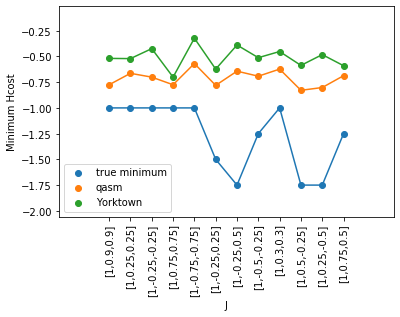

In [371]:
xx = np.arange(1,13)
print(true)

plt.scatter(xx,true, label = 'true minimum')
plt.scatter(xx,qas, label = 'qasm')
plt.scatter(xx,york, label = 'Yorktown')
plt.plot(xx,true)
plt.plot(xx,qas)
plt.plot(xx,york)
plt.xlabel("J")
plt.ylabel("Minimum Hcost")
plt.xticks(xx, J, rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.legend()
plt.show()

In [468]:
from scipy.linalg import expm

def QAOAn3_classically(J,gamma,beta):
    I = np.identity((2))
    Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])
    z1 = np.kron(Z,np.kron(I,I))
    z2 = np.kron(I,np.kron(Z,I))
    z3 = np.kron(I,np.kron(I,Z))
    
    H = [[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]]
    h1 = np.kron(H,np.kron(I,I))
    h2 = np.kron(I,np.kron(H,I))
    h3 = np.kron(I,np.kron(I,H))
    
    im = complex(0,1) # define the imaginary unit
    
    # initial state all zeros (s0 the 1,0,0,0,0,0,0,0)
    s_i = np.array([1,0,0,0,0,0,0,0])
    
    # Add a H gate on all qubits
    s = np.dot(h1,s_i)
    s = np.dot(h2,s)
    s = np.dot(h3,s)
        
    def rx(theta):
        return expm(-im*(theta/2)*X)
    
    rx1 = np.kron(rx(2*beta),np.kron(I,I))
    rx2 = np.kron(I,np.kron(rx(2*beta),I))
    rx3 = np.kron(I,np.kron(I,rx(2*beta)))
    
    Hc = J[0]*np.dot(z1,z2) + J[1]*np.dot(z2,z3) + J[2]*np.dot(z3,z1)
    H_mat = expm(-im*gamma*Hc)
    
    s = np.dot(H_mat,s)
    s = np.dot(rx1,s)
    s = np.dot(rx2,s)
    s = np.dot(rx3,s)

    return s
  

In [469]:
state_f = QAOAn3_classically([-1,-1,-1],5.52,2.32)

In [470]:
state_abs = np.abs(state_f)

In [471]:
print(state_abs)

[0.70689672 0.00995024 0.00995024 0.00995024 0.00995024 0.00995024
 0.00995024 0.70689672]


In [348]:
# J = [1,0.9,0.9] vs p

opt_QAOA([-1,-1,-1],1,20)

[0.68431272 4.09681168]


-2.9480000000000004

In [313]:
opts = []
ps = []
for i in range(1,10):
    ps.append(i)
    opts.append(opt_QAOA([1,-0.25,0.25],i,250))
plt.plot(ps,opts)
plt.xlabel("p")
plt.ylabel("QAOA min eig")
plt.title("Optimization QAOA for J = [1,-0.25,0.25] (true value -1.5) vs p")
plt.show

KeyboardInterrupt: 